In [ ]:
import argparse
import json
from pathlib import Path

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from scripts.lib import get_standards_characteristics, load_target_minerals, get_formula, load_images, load_standards_df

def get_variable_percent(formula, n, epsilon=.0001):
    elements = [
        {'element': e, 'min': m[0], 'max': m[1]}
        for e, m in formula.items()
    ]

    base = sum([e['min'] for e in elements])
    remainder = 1 - base
    element_remainders = [e['max'] - e['min'] for e in elements]

    v = np.hstack([
        np.random.uniform(0, e, (n, 1)) for e in element_remainders
    ])

    while remainder > 0:
        s = v.sum(axis=1, keepdims=True)
        v = (v/s)*remainder
        mask = v < element_remainders
        r = np.clip(v - element_remainders, 0, None)
        v = v - r
        v = v + (mask * (r.sum(axis=1) / mask.sum(axis=1)).reshape(-1, 1))
        if np.abs(remainder - v.sum(axis=1)).mean() < epsilon:
            break

    return [(e['element'], e['min']+v[:, i]) for i, e in enumerate(elements)]

def simulate_mineral(mineral, formula, standard_elements, n=5):
    if not isinstance(formula, list):
        formula = [formula]

    #elements = []
    #masses = []

    mineral_elements = {}
    def append(element, mass):
        if element in mineral_elements:
            mineral_elements[element] += mass
        else:
            mineral_elements[element] = mass

    for component in formula:
        if isinstance(component, str):
            for element, mass in get_formula(component, format="mass").items():
                append(element, np.ones(n)*mass)
        elif isinstance(component, dict):
            if 'quantity' in component:
                quantity = component['quantity']
                if isinstance(quantity, list):
                    quantity = np.random.randint(quantity[0], quantity[1]+1)
            else:
                quantity = 1

            for molecule, percent in get_variable_percent(component['components'], n):
                for element, mass in get_formula(molecule, format="mass").items():
                    append(element, percent*mass*quantity)
        else:
            raise ValueError(f"{str(component)} is not a recognized format")

    # Calculate mass percents
    df = pd.DataFrame(mineral_elements)
    df.columns = [f"{element}_mass" for element in df.columns]
    df['mass'] = df.sum(axis=1)
    for element in mineral_elements:
        df[f"{element}_percent"] = df[f"{element}_mass"]/df['mass']

    # Convert to intensities
    for element in standard_elements:
        e = standard_elements[element]
        df[element] = (
            e['intercept'] + np.random.normal(scale=e['noise'], size=n)
        )

        if f"{element}_percent" in df:
            df[element] += (
                e['coef']*df[f"{element}_percent"] +
                np.random.normal(scale=e['std'], size=n)
            )

        df[element] = np.clip(df[element], 0, None)


    '''mineral_elements = get_formula(component)
    for element, weight in mineral_elements.items():
        elements.append(element)
        masses.append(np.ones(n)*weight)'''

    df['mineral'] = mineral
    #df['formula'] = formula

    #return elements, masses
    return df





In [177]:
standards_dir = Path('challenge_data/dataset_1_opaques/standards/')
bits = 32
target_minerals_file = Path('challenge_data/dataset_1_opaques/target_minerals.yaml')
meteorite_dir = Path('challenge_data/dataset_1_opaques/obj1/')

characteristics = get_standards_characteristics(standards_dir, bits)
'''target_minerals = load_target_minerals(target_minerals_file)
#print(characteristics)
elements = list(characteristics.keys())
#

mineral_dfs = []
for mineral, formula in target_minerals.items():
    #print(mineral)

    df = simulate_mineral(mineral, formula, characteristics, 10000)
    #print(df.head())
    mineral_dfs.append(df[elements + ['mineral']])

df = pd.concat(mineral_dfs)'''

Loading standards...
Successfully loaded 10 standards with 8 masks

Loaded 29209 rows
Mineral counts:
{
    "NiS": 4644,
    "FeS": 4115,
    "SCOlv": 4043,
    "Fe3O4": 3969,
    "Fe": 3819,
    "rutile": 3607,
    "CaTiO3": 3470,
    "Ni": 1542
}


"target_minerals = load_target_minerals(target_minerals_file)\n#print(characteristics)\nelements = list(characteristics.keys())\n#\n\nmineral_dfs = []\nfor mineral, formula in target_minerals.items():\n    #print(mineral)\n\n    df = simulate_mineral(mineral, formula, characteristics, 10000)\n    #print(df.head())\n    mineral_dfs.append(df[elements + ['mineral']])\n\ndf = pd.concat(mineral_dfs)"

In [179]:
# Build model to predict standards

df = load_standards_df(standards_dir, 32)
#df = df[~df['mineral'].isin(['rutile', 'SCOlv'])]
#df = df[~df['mineral'].isin(['Fe'])][elements + ['mineral']]
unknown = pd.DataFrame(np.clip(
    np.hstack([
        np.random.uniform(-m, m, (10000, 1)) for m in df[elements].max(axis=0)
    ]), 0, None), columns=elements
)
unknown['mineral'] = 'Unknown'
df = pd.concat([df, unknown])


elements = list(characteristics.keys())
X = df[elements].values
Y = df['mineral']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

print("Training Classifier...")
#model = RandomForestClassifier(100, max_depth=10, n_jobs=-1)

# Worked very well! I Think!
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model = BaggingClassifier(
    model,
    n_estimators=100, 
    max_samples=.8, max_features=.5,
    n_jobs=-1
)
#from sklearn.mixture import GaussianMixture
#model = GaussianMixture(len(elements))
#model = RandomForestClassifier(5, max_depth=10, criterion='entropy')
'''model = BaggingClassifier(
    RandomForestClassifier(5, max_depth=10, criterion='entropy'), 
    #DecisionTreeClassifier(max_depth=10, criterion='entropy'),
    n_estimators=20, 
    max_samples=.8, #max_features=.5,
    n_jobs=-1
)
model = AdaBoostClassifier(model, n_estimators=5)'''
model.fit(X_train, Y_train)
print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

Loading standards...
Successfully loaded 10 standards with 8 masks

Loaded 29209 rows
Mineral counts:
{
    "NiS": 4644,
    "FeS": 4115,
    "SCOlv": 4043,
    "Fe3O4": 3969,
    "Fe": 3819,
    "rutile": 3607,
    "CaTiO3": 3470,
    "Ni": 1542
}
Training Classifier...


/home/docmario/miniconda3/envs/haiku/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


Training Accuracy: 0.9738259954729492
Testing Accuracy: 0.9739862280030605


In [78]:
df

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral
0,0.000000,1.469007,0.000000,197.428166,76.797756,0.341705,1.842108,Millerite
1,0.000000,0.000000,0.000000,219.369733,82.942572,0.000000,0.000000,Millerite
2,0.000000,0.267993,0.000000,191.746001,63.775523,1.325980,0.000000,Millerite
3,0.031266,0.694524,0.298910,164.041905,83.260433,1.058199,0.000000,Millerite
4,1.228090,0.000000,0.000000,191.168748,64.510156,0.294245,0.000000,Millerite
5,1.247729,0.000000,0.000000,188.096172,85.139857,0.073454,0.757183,Millerite
6,0.877652,0.000000,0.190210,184.019872,68.306335,1.098069,0.167278,Millerite
7,0.000000,0.000000,0.098569,207.860988,90.231098,0.000000,0.000000,Millerite
8,1.026475,1.021862,0.000000,207.295911,82.931543,0.000000,0.000000,Millerite
9,1.012761,0.000000,0.081543,161.053835,87.866716,2.076730,1.888487,Millerite


In [186]:
target_minerals

{'Millerite': 'NiS',
 'Troilite': 'FeS',
 'Wollastonite': 'Ca2Si2O6',
 'Anorthite': 'CaAl2Si2O8',
 'Diopside': 'CaMgSi2O6',
 'Albite': 'NaAlSi3O8',
 'Olivine': [{'components': {'Fe': [0, 1], 'Mg': [0, 1]}, 'quantity': 2},
  'SiO4'],
 'Pyroxene': [{'components': {'Fe': [0, 1], 'Mg': [0, 1]}}, 'SiO3'],
 'Taenite': {'components': {'Fe': [0.5, 0.9], 'Ni': [0.1, 0.5]}},
 'Kamacite': {'components': {'Fe': [0.9, 0.9], 'Ni': [0.1, 0.1]}},
 'Schreibersite': [{'components': {'Fe': [0.4, 0.6], 'Ni': [0.4, 0.6]},
   'quantity': 3},
  'P'],
 'Pentlandite': [{'components': {'Fe': [0.3, 0.7], 'Ni': [0.3, 0.7]},
   'quantity': 9},
  'S8'],
 'MSS': [{'components': {'Fe': [0, 1], 'Ni': [0, 1]}, 'quantity': 1}, 'S']}

In [280]:
# From targets file

target_minerals = load_target_minerals(target_minerals_file)
#target_minerals = load_target_minerals(Path('challenge_data/dataset_1_opaques/target_minerals_test.yaml'))
elements = list(characteristics.keys())
mineral_dfs = []
for mineral, formula in target_minerals.items():
    #print(mineral)

    df = simulate_mineral(mineral, formula, characteristics, 10000)
    #print(df.head())
    mineral_dfs.append(df[elements + ['mineral']])

df = pd.concat(mineral_dfs)

'''unknown = pd.DataFrame(np.clip(
    np.hstack([
        np.random.uniform(-2*m, m, (10000, 1)) for m in df[elements].max(axis=0)
    ]), 0, None), columns=elements
)
unknown['mineral'] = 'Unknown'
df = pd.concat([df, unknown])'''

X = df[elements].values
Y = df['mineral']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

from sklearn.svm import SVC
#model = SVC(max_iter=500)

# Shit
#from sklearn.linear_model import Perceptron
#model = Perceptron()



'''model = BaggingClassifier(
    model,
    n_estimators=100, 
    max_samples=.8, max_features=.9,
    n_jobs=-1
)'''
#from sklearn.mixture import GaussianMixture
#model = GaussianMixture(len(elements))
#model = RandomForestClassifier(5, max_depth=10, criterion='entropy')
'''model = BaggingClassifier(
    RandomForestClassifier(5, max_depth=10, criterion='entropy'), 
    #DecisionTreeClassifier(max_depth=10, criterion='entropy'),
    n_estimators=20, 
    max_samples=.8, #max_features=.5,
    n_jobs=-1
)
model = AdaBoostClassifier(model, n_estimators=5)'''
model.fit(X_train, Y_train)
print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

Training Accuracy: 0.9335961538461538
Testing Accuracy: 0.9315384615384615


In [103]:
model.sigma_

array([[1.98664873e-01, 4.23314626e-01, 6.42644140e-02, 6.01903147e-01,
        9.24814810e-03, 1.66683521e+02, 1.65778147e+00],
       [1.28721357e+02, 4.28019332e-01, 6.49779184e-02, 6.17853701e-01,
        9.46181330e-03, 1.69994552e+02, 1.67067852e+00],
       [1.26935930e+02, 4.16449881e-01, 1.91757870e+02, 6.01515826e-01,
        9.47742833e-03, 1.61118750e+02, 1.70092134e+00],
       [2.10307768e-01, 1.54347515e+02, 6.52471304e-02, 2.15514665e+02,
        9.19460875e-03, 5.28829477e-01, 1.67355547e+00],
       [2.06249337e-01, 4.12670447e-01, 6.20926574e-02, 2.19301772e+02,
        7.40530215e+01, 5.14464929e-01, 1.64371001e+00],
       [2.05026546e-01, 1.74825604e+03, 4.83119612e+03, 6.19487347e-01,
        9.16899942e-03, 3.77644040e+02, 1.64903984e+00],
       [2.10550725e-01, 1.51146678e+02, 6.17517516e-02, 2.21495025e+02,
        7.39166509e+01, 5.13232564e-01, 1.67813202e+00],
       [2.00841306e-01, 1.09481553e+03, 2.47869247e+03, 6.25924900e-01,
        9.41156281e-03, 4

In [82]:
df[df['mineral'] == 'Kamacite']

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral
0,0.550937,287.083768,0.000000,31.585619,0.000000,0.000000,0.000000,Kamacite
1,1.568077,301.775656,0.319846,24.812235,0.000000,0.000000,0.754259,Kamacite
2,0.000000,277.164511,0.651887,25.088419,0.135815,0.000000,0.954545,Kamacite
3,0.639408,291.745153,0.000000,31.815249,0.000000,0.000000,2.315130,Kamacite
4,0.000000,287.971456,0.000000,50.008364,0.162291,0.000000,0.728218,Kamacite
5,0.425726,264.199583,0.000000,25.663310,0.000000,1.729277,0.000000,Kamacite
6,0.000000,279.734222,0.000000,13.430697,0.255465,0.000000,0.000000,Kamacite
7,0.000000,274.954737,0.000000,39.056824,0.000000,1.005442,0.043369,Kamacite
8,0.000000,284.976262,0.346809,24.015376,0.000000,1.245173,0.823881,Kamacite
9,0.385010,273.633041,0.467068,5.212668,0.000000,1.302657,0.000000,Kamacite


In [94]:
df[
    (df['mineral'] == 'Kamacite') & 
    (df['Ni'] < 10) &
    (df['Fe'].between(220, 250)) &
    
    (df['Ca'] < 10) &
    (df['Mg'] < 10) &
    (df['S'] < 10) &
    (df['Si'] < 10) &
    (df['Ti'] < 10)
]

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral
1544,0.000000,245.849715,0.673118,7.858273,0.000000,0.173316,1.773233,Kamacite
3664,0.000000,248.794196,0.263206,0.000000,0.132469,1.922825,0.000000,Kamacite
4676,0.000000,249.624318,0.000000,5.464705,0.000000,0.000000,0.000000,Kamacite
5745,0.059050,244.410844,0.000000,8.576029,0.000000,1.998629,1.636945,Kamacite
6353,0.613602,248.115186,0.000000,0.000000,0.191497,0.000000,2.211895,Kamacite
7355,1.024550,249.628036,0.000000,0.000000,0.275159,0.353691,1.940684,Kamacite
8830,1.072282,244.388111,0.187322,9.943897,0.000000,0.238180,3.616631,Kamacite
9539,0.517998,244.680868,0.000000,6.937723,0.000000,0.000000,0.498195,Kamacite


In [93]:
df[
    (df['mineral'] == 'Unknown') & 
    (df['Ni'] < 10) &
    (df['Fe'].between(220, 250)) &
    
    (df['Ca'] < 10) &
    (df['Mg'] < 10) &
    (df['S'] < 10) &
    (df['Si'] < 10) &
    (df['Ti'] < 10)
]

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral
63,0.000000,226.218822,0.000000,0.0,0.000000,0.0,0.000000,Unknown
324,0.000000,240.282950,0.000000,0.0,0.000000,0.0,0.000000,Unknown
670,0.000000,232.474870,0.000000,0.0,0.000000,0.0,0.000000,Unknown
685,0.000000,223.031787,0.000000,0.0,0.000000,0.0,0.000000,Unknown
1032,0.000000,244.148156,0.000000,0.0,0.000000,0.0,0.000000,Unknown
1254,0.000000,237.334513,0.000000,0.0,0.000000,0.0,0.000000,Unknown
1314,0.000000,227.577199,0.000000,0.0,0.000000,0.0,0.000000,Unknown
1824,0.000000,248.035336,0.000000,0.0,0.000000,0.0,7.460069,Unknown
1904,0.000000,244.680872,0.000000,0.0,0.000000,0.0,1.910192,Unknown
2038,0.000000,231.024881,0.000000,0.0,0.000000,0.0,0.000000,Unknown


In [87]:
meteorite_df

,order,Al,Ca,Cr,Fe,Mg,Ni,P,S,Si,Ti,mineral
0,0,0,0,6,292,0,3,0,0,4,11,Unknown
1,1,0,0,9,202,0,0,0,0,0,9,Unknown
2,2,0,0,9,205,0,0,3,0,0,6,Unknown
3,3,0,0,3,206,0,2,4,0,3,4,Unknown
4,4,2,0,7,210,0,2,0,0,0,8,Unknown
5,5,0,0,7,222,0,2,0,0,0,0,Kamacite
6,6,0,0,4,224,0,2,0,0,0,5,Kamacite
7,7,0,0,3,226,0,0,2,0,0,4,Kamacite
8,8,0,0,7,209,1,0,4,0,0,7,Unknown
9,9,0,0,6,251,0,2,0,0,0,3,Kamacite


In [84]:
proba = model.predict_proba(x)
proba

array([[1.61820484e-145, 2.75903674e-065, 2.09922557e-118, ...,
        8.18075383e-022, 8.59827640e-001, 2.41394580e-128],
       [6.03540986e-144, 2.44149126e-062, 4.84841611e-116, ...,
        1.88440072e-001, 5.13543210e-001, 1.51175737e-125],
       [8.15002217e-144, 2.61916856e-062, 1.00141662e-115, ...,
        1.89999934e-001, 3.17230334e-001, 4.83865452e-125],
       ...,
       [6.22003038e-130, 1.01179189e-053, 9.07642442e-106, ...,
        2.73947065e-064, 1.00000000e+000, 1.31638989e-113],
       [2.16537112e-131, 2.12436231e-055, 6.65452239e-105, ...,
        5.87617550e-066, 1.00000000e+000, 3.38822827e-115],
       [5.17833548e-132, 1.30985267e-052, 1.50884020e-104, ...,
        1.81550127e-066, 1.00000000e+000, 7.30186085e-112]])

In [89]:
proba[5:8]#.max(axis=1)

array([[1.67738903e-144, 4.12762641e-063, 2.83747432e-116,
        5.66847326e-001, 5.78535383e-055, 1.35294368e-001,
        1.27551425e-021, 5.95336776e-004, 1.06889344e-001,
        1.89999016e-001, 3.74610233e-004, 1.75468636e-125],
       [1.50223220e-144, 4.17170008e-063, 2.06120919e-116,
        5.83362774e-001, 5.74253148e-055, 1.08584447e-001,
        8.01122550e-022, 5.23981905e-004, 1.02049857e-001,
        1.89997043e-001, 1.54818982e-002, 1.02201778e-125],
       [8.92412528e-144, 2.60482318e-062, 1.33626448e-115,
        5.83740502e-001, 1.36287419e-055, 1.40252528e-001,
        2.76491285e-022, 5.00921775e-004, 8.40935759e-002,
        1.89998690e-001, 1.41378138e-003, 7.80430094e-125]])

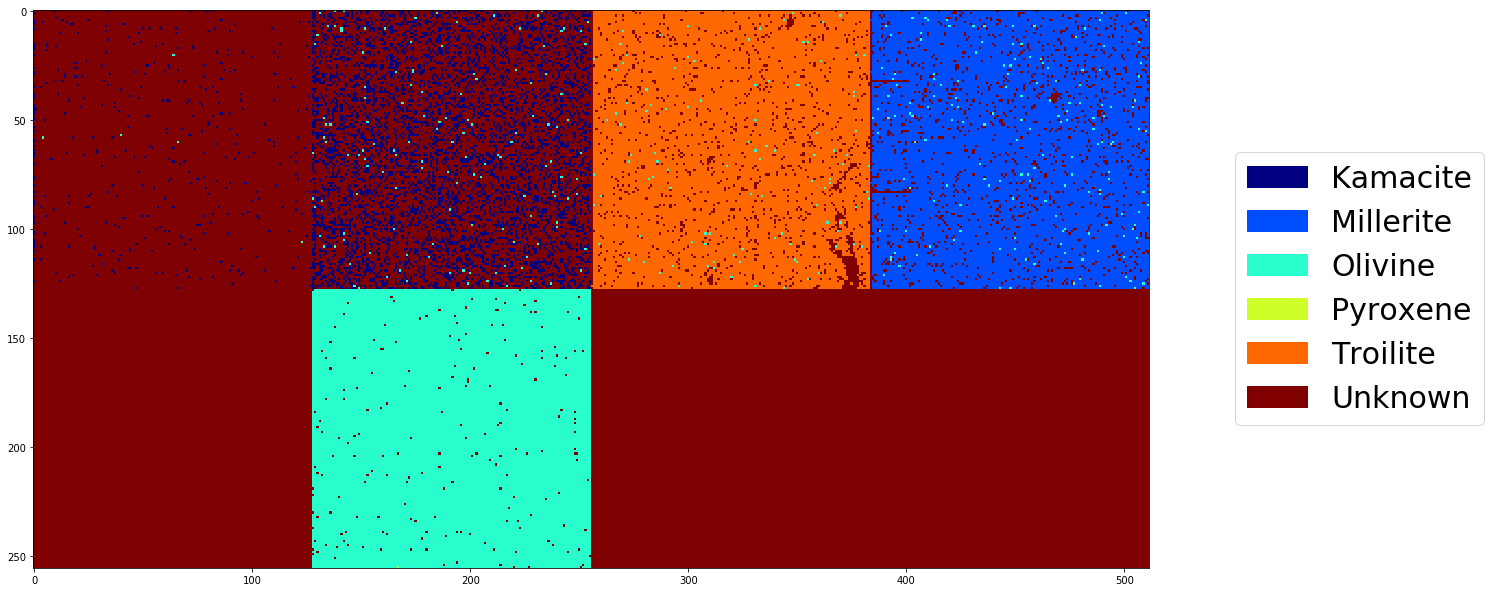

In [122]:
meteorite_df, meteorite_shape = load_images(standards_dir, bits)
x = meteorite_df[elements].values
meteorite_df['mineral'] = model.predict(x)
#print(meteorite_df.head(20))
minerals = sorted(meteorite_df['mineral'].unique())
results = meteorite_df.merge(
    pd.Series(
        minerals, name='mineral'
    ).reset_index().rename(columns={'index': 'mineral_index'}),
    on='mineral'
).sort_values('order')

figure, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(
    results['mineral_index'].values.reshape(meteorite_shape),
    cmap=plt.cm.get_cmap('jet', len(minerals))
)
colors = [im.cmap(im.norm(i)) for i in range(len(minerals))]
patches = [
    mpatches.Patch(
        color=colors[i], label=minerals[i]
    ) for i in range(len(minerals))
]
ax.legend(
    handles=patches, bbox_to_anchor=(1.3, .5, 0, 0),
    loc=5, borderaxespad=0., fontsize=30
)
#if title:
#    figure.suptitle(title, fontsize=30, y=.91)

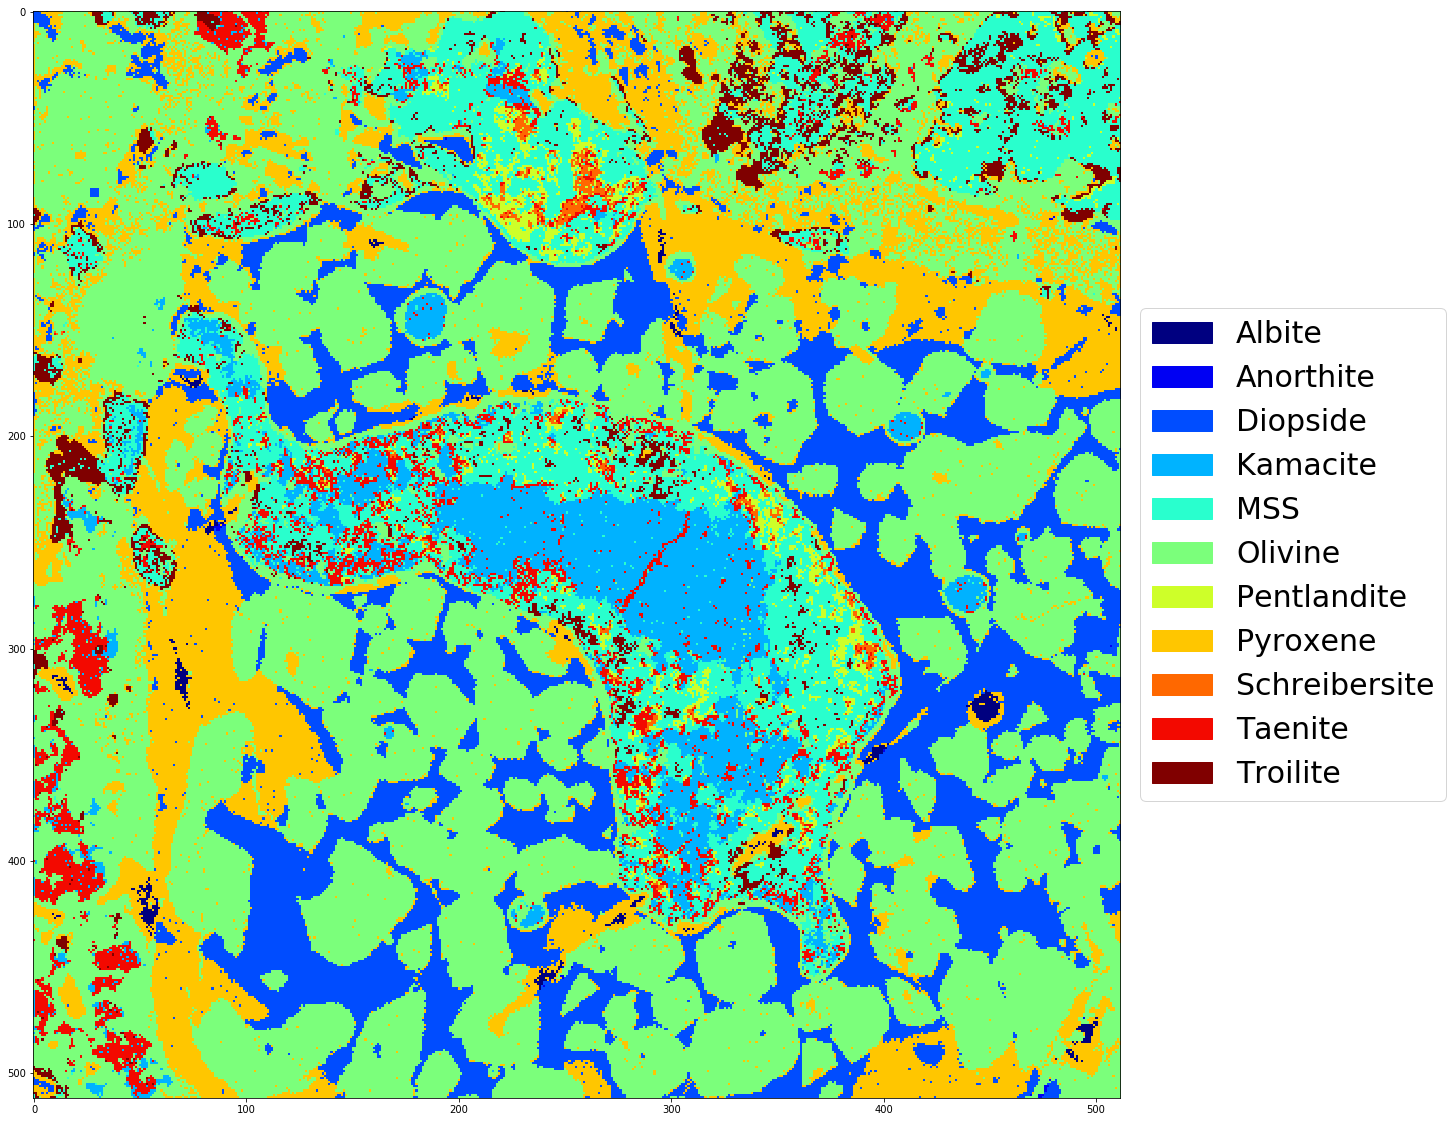

In [281]:
meteorite_df, meteorite_shape = load_images(meteorite_dir, bits)
x = meteorite_df[elements].values
meteorite_df['mineral'] = model.predict(x)
#print(meteorite_df.head(20))
minerals = sorted(meteorite_df['mineral'].unique())
results = meteorite_df.merge(
    pd.Series(
        minerals, name='mineral'
    ).reset_index().rename(columns={'index': 'mineral_index'}),
    on='mineral'
).sort_values('order')

figure, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(
    results['mineral_index'].values.reshape(meteorite_shape),
    cmap=plt.cm.get_cmap('jet', len(minerals))
)
colors = [im.cmap(im.norm(i)) for i in range(len(minerals))]
patches = [
    mpatches.Patch(
        color=colors[i], label=minerals[i]
    ) for i in range(len(minerals))
]
ax.legend(
    handles=patches, bbox_to_anchor=(1.3, .5, 0, 0),
    loc=5, borderaxespad=0., fontsize=30
)
#if title:
#    figure.suptitle(title, fontsize=30, y=.91)

In [282]:
model.predict_proba(x)

array([[0.00000000e+000, 0.00000000e+000, 1.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [6.35973223e-191, 2.45381210e-072, 1.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 2.48414715e-100],
       ...,
       [0.00000000e+000, 0.00000000e+000, 4.40406003e-067, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 9.84957529e-060, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 6.88896109e-079, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000]])

In [137]:
results[results['mineral'] == 'Pentlandite'][elements]

,Ca,Fe,Mg,Ni,S,Si,Ti
196056,2,115,0,8,45,72,6
196057,0,179,0,21,70,3,6
196058,2,168,0,41,66,2,0
196059,2,185,17,40,80,4,3
196060,6,175,6,18,13,82,4
196061,7,133,3,19,18,100,2
196062,0,110,3,23,34,114,4
196063,8,119,1,44,44,84,2
196064,0,118,3,18,32,91,2
196065,5,124,4,38,37,103,6


In [175]:
df[df['mineral'] == 'Pentlandite'].mean()

Ca      0.313786
Fe    118.624875
Mg      0.170135
Ni    121.301139
S      45.970638
Si      0.489542
Ti      0.899407
dtype: float64

In [221]:
from sklearn.cluster import KMeans
a = results[results['mineral'] == 'Unknown'][elements].values
k = KMeans(50)
k.fit(a)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [247]:
for i, row in pd.DataFrame(k.cluster_centers_, columns=elements).iterrows():
    d = {}
    for e in row.keys():
        #print(e, row[e])
        q = row[e]/characteristics[e]['coef']
        if q > .01:
            d[e] = q
    if ('S' in d):
        print(d['S'])
    if ('S' in d) and (np.abs(d['S'] - .33) < .15):
        print(i, (k.labels_ == i).sum(), d)
        #print(d['S'])

0.043254803278584594
0.01833905603867208
0.012945646062207657
0.010115068262674637
0.034271898082915114
0.07490625922809603
0.23560099903350615
11 2941 {'Fe': 0.48534187715002264, 'Ni': 0.12535678331092936, 'S': 0.23560099903350615, 'Si': 0.020019359756882377}
0.012791784134575502
0.06779637173405685
0.05287441167714017
0.04481676642729583
0.22702046320810942
27 3580 {'Fe': 0.5869659323508608, 'Ni': 0.040577697424273015, 'S': 0.22702046320810942, 'Si': 0.012293009493465429}
0.03333535566959529
0.01812236965913867
0.03395888574474639
0.04643851341626682
0.12013659400279436
0.023336779448422034
0.053612830692156915
0.027606244290874635
0.03765245739055029
0.018650257471274297
0.05559978878055042


In [259]:
from sklearn.cluster import KMeans
a = results[results['mineral'] == 'Unknown'][['S']].values
km = KMeans(50)
km.fit(a)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [260]:
labels = []

for i in range(len(km.cluster_centers_)):
    w = km.cluster_centers_[i]/characteristics['S']['coef']
    if (w > .25) and (w < .45):
        print(i, w)
        labels.append(i)

5 [0.31339572]
12 [0.38690902]
13 [0.27830156]
19 [0.34378537]
23 [0.26860072]
24 [0.28759519]
30 [0.44186503]
32 [0.25905969]
40 [0.36260057]
41 [0.2979747]
45 [0.32757834]


In [263]:
for i in labels:

    d = dict(results[results['mineral'] == 'Unknown'][elements].iloc[km.labels_ == i].mean())
    for k in d:
        d[k] = d[k]/characteristics[k]['coef']
    print([(e, m) for e,m in d.items() if m > .01])

[('Fe', 0.5423877753783481), ('Ni', 0.07641124932889268), ('S', 0.3133957185960041), ('Si', 0.017419602108530673)]
[('Fe', 0.5665445334879438), ('Ni', 0.07127772984449302), ('S', 0.3869090211470506), ('Si', 0.012962089005921926)]
[('Fe', 0.5289893044816136), ('Ni', 0.09148409555019807), ('S', 0.27830155839963167), ('Si', 0.02059463632962449)]
[('Fe', 0.5464839600821253), ('Ni', 0.07681453213768513), ('S', 0.343785366109694), ('Si', 0.0159221458695716)]
[('Fe', 0.5266962799716335), ('Ni', 0.08532235942412679), ('S', 0.26860072043027927), ('Si', 0.022058031978614577)]
[('Fe', 0.5313043138862245), ('Ni', 0.08748277784701668), ('S', 0.28759519115027554), ('Si', 0.020638602566537812)]
[('Fe', 0.6417268410213972), ('Mg', 0.023231733432347586), ('Ni', 0.018456124606644333), ('S', 0.4418650309845805), ('Si', 0.010411738836399762)]
[('Fe', 0.5227335197744251), ('Ni', 0.09516699440027582), ('S', 0.2590596879970779), ('Si', 0.021589208730079718)]
[('Fe', 0.5552201888999893), ('Mg', 0.010130588772

In [266]:
df[df['mineral'] == 'MSS'].mean()

Ca     0.306536
Fe    97.543105
Mg     0.170410
Ni    99.318002
S     75.339158
Si     0.509253
Ti     0.877796
dtype: float64

In [269]:
97 / characteristics['Fe']['coef'], 99 / characteristics['Ni']['coef'], 75 / characteristics['S']['coef']

(0.3116958942103929, 0.3269648180313938, 0.35656830031983555)

In [273]:
copy = df[df['mineral'] == 'MSS'].copy()
copy

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral
0,0.176753,60.400341,0.103651,114.081034,84.815714,1.444787,0.000000,MSS
1,0.000000,171.100805,0.424332,9.117366,87.421690,0.000000,0.000000,MSS
2,0.000000,107.815181,0.344426,87.296592,76.874356,0.000000,5.040659,MSS
3,0.000000,89.672927,0.260223,101.558906,71.669939,0.455732,0.000000,MSS
4,0.000000,76.820742,0.197545,80.246762,76.202110,0.000000,0.000000,MSS
5,0.000000,62.867541,0.219865,98.389267,81.875464,0.000000,1.399031,MSS
6,0.711488,86.657158,0.432846,107.665924,70.037727,1.124953,1.655112,MSS
7,0.000000,95.481833,0.599723,98.571817,84.284818,0.517580,2.548344,MSS
8,0.331076,182.325949,0.000000,21.967955,64.666066,0.819071,0.000000,MSS
9,0.250140,101.500396,0.969272,124.638051,81.849988,0.692680,0.000000,MSS


In [274]:
copy['Fe_w'] = copy['Fe'] / characteristics['Fe']['coef']
copy['Ni_w'] = copy['Ni'] / characteristics['Ni']['coef']
copy['S_w'] = copy['S'] / characteristics['S']['coef']
copy

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral,Fe_w,Ni_w,S_w
0,0.176753,60.400341,0.103651,114.081034,84.815714,1.444787,0.000000,MSS,0.194088,0.376773,0.403235
1,0.000000,171.100805,0.424332,9.117366,87.421690,0.000000,0.000000,MSS,0.549808,0.030112,0.415624
2,0.000000,107.815181,0.344426,87.296592,76.874356,0.000000,5.040659,MSS,0.346449,0.288312,0.365479
3,0.000000,89.672927,0.260223,101.558906,71.669939,0.455732,0.000000,MSS,0.288151,0.335416,0.340736
4,0.000000,76.820742,0.197545,80.246762,76.202110,0.000000,0.000000,MSS,0.246853,0.265029,0.362283
5,0.000000,62.867541,0.219865,98.389267,81.875464,0.000000,1.399031,MSS,0.202016,0.324948,0.389256
6,0.711488,86.657158,0.432846,107.665924,70.037727,1.124953,1.655112,MSS,0.278461,0.355586,0.332976
7,0.000000,95.481833,0.599723,98.571817,84.284818,0.517580,2.548344,MSS,0.306817,0.325551,0.400711
8,0.331076,182.325949,0.000000,21.967955,64.666066,0.819071,0.000000,MSS,0.585879,0.072553,0.307438
9,0.250140,101.500396,0.969272,124.638051,81.849988,0.692680,0.000000,MSS,0.326157,0.411639,0.389135


In [277]:
copy[copy['Fe_w'].between(.5, .6)]

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral,Fe_w,Ni_w,S_w
1,0.000000,171.100805,0.424332,9.117366,87.421690,0.000000,0.000000,MSS,0.549808,0.030112,0.415624
8,0.331076,182.325949,0.000000,21.967955,64.666066,0.819071,0.000000,MSS,0.585879,0.072553,0.307438
32,1.370130,162.157785,0.000000,23.767449,78.614066,0.307186,0.000000,MSS,0.521071,0.078496,0.373750
39,0.237351,172.649426,0.018399,26.477649,62.629469,0.000000,1.891429,MSS,0.554785,0.087447,0.297756
44,0.000693,164.083935,0.409748,19.542816,69.283493,0.000000,0.000000,MSS,0.527261,0.064544,0.329391
46,1.281448,185.371907,0.142900,0.787915,87.115717,0.924796,0.000000,MSS,0.595667,0.002602,0.414169
48,0.320288,157.968711,0.129269,33.561638,78.770197,0.000000,2.729087,MSS,0.507610,0.110843,0.374493
60,0.871914,166.728275,0.000000,16.758604,96.380085,1.443008,4.931057,MSS,0.535758,0.055348,0.458214
68,0.000000,170.692021,0.000000,20.006275,88.725895,0.347674,0.000000,MSS,0.548495,0.066074,0.421825
76,0.547397,171.645932,0.143542,12.784257,62.778623,0.032984,0.703761,MSS,0.551560,0.042222,0.298465


In [235]:
periodictable.formula('48%wt Fe // 12%wt Ni // 23%wt S // 2%wt Si // O')

formula('Fe12.0701Ni2.87107S10.0728SiO13.1656')

In [212]:
#periodictable.formula('Fe2SO3').mass_fraction

{Fe: 0.5824674633852265, S: 0.167220155908741, O: 0.25031238070603257}

In [209]:
periodictable.formula('Mg2SiO3').mass_fraction

{Mg: 0.3898352523022414, Si: 0.2252359180936968, O: 0.3849288296040618}

In [207]:
periodictable.formula('Fe.9Ni.1').mass_fraction

{Fe: 0.8954328036566646, Ni: 0.10456719634333539}

In [195]:
import periodictable
periodictable.formula('Fe4.5Ni4.5S8').mass_fraction

{Fe: 0.32554549378529085, Ni: 0.342150091949818, S: 0.3323044142648911}

In [214]:
periodictable.formula('Ni9S8').mass_fraction

{Ni: 0.6731232429354889, S: 0.32687675706451114}

In [215]:
periodictable.formula('NiS').mass_fraction

{Ni: 0.6466993688738453, S: 0.35330063112615473}

In [197]:
periodictable.formula('CaMgSi2O6').mass_fraction

{Ca: 0.18507469854592742,
 Mg: 0.11223715125901407,
 Si: 0.25938996187492613,
 O: 0.4432981883201324}

In [227]:
periodictable.formula('(Mg1.6Fe.4)SiO4').mass_fraction

{Mg: 0.2536574802148079,
 Fe: 0.1457056365212502,
 Si: 0.1831952571634691,
 O: 0.4174416261004728}

In [192]:
characteristics

{'Ca': {'element': 'Ca',
  'coef': 462.18178605580886,
  'intercept': 0.0,
  'std': 11.257305019123992,
  'noise': 0.7839330547100091},
 'Fe': {'element': 'Fe',
  'coef': 311.200762671983,
  'intercept': 0.0,
  'std': 12.186647205139565,
  'noise': 1.1155958908410433},
 'Mg': {'element': 'Mg',
  'coef': 840.6351519819596,
  'intercept': 0.0,
  'std': 13.785308695058687,
  'noise': 0.4296300849188238},
 'Ni': {'element': 'Ni',
  'coef': 302.78487023791786,
  'intercept': 0.0,
  'std': 14.881467710431,
  'noise': 1.329300610782891},
 'S': {'element': 'S',
  'coef': 210.33838378993957,
  'intercept': 0.0,
  'std': 8.65963719514509,
  'noise': 0.16686134572119973},
 'Si': {'element': 'Si',
  'coef': 1016.951679300757,
  'intercept': 0.0,
  'std': 12.817817389598144,
  'noise': 1.2343527334863311},
 'Ti': {'element': 'Ti',
  'coef': 1286.594667115852,
  'intercept': 0.0,
  'std': 21.114220834883863,
  'noise': 2.2062585039462057}}

In [166]:
from sklearn.cluster import DBSCAN
d = DBSCAN(11)
a = results[results['mineral'] == 'Pentlandite'][elements].values
b = d.fit_predict(a)

In [167]:
for i in range(0, b.max()+1):
    print((b == i).sum())

31570
4
7
3
5
7
5
4
6
3


In [165]:
b

array([ 0,  0,  0, ..., -1,  0,  0])

In [148]:
len(d.components_)

32694

In [151]:
d.

array([    0,     1,     2, ..., 32694, 32695, 32696])